In [1]:
import torch, torch.nn.functional as F
import torch.nn as nn
from torchvision.datasets.cifar import CIFAR10
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm import tqdm
from pathlib import Path
import numpy as np
import random
import pandas as pd
import statistics as stats
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn import svm

In [2]:
class Encoder(nn.Module):
    def __init__(self, 
                 num_features = 64,
                 output_size = 64, 
                 input_size = (32, 32)):
        super(Encoder, self).__init__()
        self.conv_input = nn.Conv2d(3, num_features, kernel_size=4)
        
        self.conv1 = nn.Conv2d(num_features, 2*num_features, kernel_size=4)
        self.batch_norm1 = nn.BatchNorm2d(2*num_features)
        
        self.conv2 = nn.Conv2d(2*num_features, 4*num_features, kernel_size=4)
        self.batch_norm2 = nn.BatchNorm2d(4*num_features)
        
        self.conv3 = nn.Conv2d(4*num_features, 8*num_features, kernel_size=4)
        self.batch_norm3 = nn.BatchNorm2d(8*num_features)
        
        n_input_lin = 8*num_features*(input_size[0] - 3*4)*(input_size[1] - 3*4)
        self.proj = nn.Linear(n_input_lin, output_size)

    def forward(self, X):
        E = F.relu(self.conv_input(X))
        M = F.relu(self.batch_norm1(self.conv1(E)))
        E = F.relu(self.batch_norm2(self.conv2(M)))
        E = F.relu(self.batch_norm3(self.conv3(E)))
        E = E.reshape(E.size()[0], E.size()[1] * E.size()[2] *  E.size()[3] )
        y = self.proj(E)
        
        return y, M

In [3]:
class GlobalDiscriminator(nn.Module):
    """
        channels_qtd: 2 * num_features(64)
        using concat and convolve architecture
    """
    def __init__(self, 
                 channels_qtd = 2*64, 
                 M_size = (26, 26), 
                 encoder_out = 64):
        super(GlobalDiscriminator, self).__init__()
        # 128 e 64
        self.conv1 = nn.Conv2d(channels_qtd, channels_qtd//2, kernel_size=3) 
        #64 e 32
        self.conv2 = nn.Conv2d(channels_qtd//2, channels_qtd//4, kernel_size=3)  
        
        # input is the concatenate of E and flattened output of convolutions
        features_inp = ( channels_qtd//4  *(M_size[0]-2*2)*(M_size[1]-2*2)) + encoder_out
        self.proj1 = nn.Linear(features_inp, 512)
        self.proj2 = nn.Linear(512, 512)
        self.proj3 = nn.Linear(512, 1)

    def forward(self, E, M):
        C = F.relu(self.conv1(M))
        C = self.conv2(C)
        
        # Flatten local features and concat with global encoding
        C = C.reshape(E.size()[0], C.size()[1] * C.size()[2] *  C.size()[3] )
        out = torch.cat((E, C), 1)
        out = F.relu(self.proj1(out))
        out = F.relu(self.proj2(out))
        out = self.proj3(out)
        return out

In [4]:
class LocalDiscriminator(nn.Module):
    """
        channels_qtd: 2 * num_features(64)
    """
    def __init__(self,
                 channels_qtd = 2*64,
                 encoder_out = 64):
        super(LocalDiscriminator, self).__init__()
        features_inp = channels_qtd  + encoder_out
        # print(features_inp)
        self.conv1 = nn.Conv2d(features_inp, 512, kernel_size=1)
        self.conv2 = nn.Conv2d(512, 512, kernel_size=1)
        self.conv3 = nn.Conv2d(512, 1, kernel_size=1)
    
    def forward(self, X):
        out = F.relu(self.conv1(X))
        out = F.relu(self.conv2(out))
        out = self.conv3(out)
        return out

In [5]:
class PriorMatching(nn.Module):
    def __init__(self,
                 encoder_out = 64):
        super(PriorMatching, self).__init__()
        self.proj1 = nn.Linear(encoder_out, 1000)
        self.proj2 = nn.Linear(1000, 200)
        self.proj3 = nn.Linear(200, 1)
    
    def forward(self, X):
        out = F.relu(self.proj1(X))
        out = F.relu(self.proj2(out))
        out = F.sigmoid(self.proj3(out))
        return out

All three objectives – global and local MI maximization and prior matching – can be used together, and here is the complete objective for Deep InfoMax

![](https://drive.google.com/uc?id=1vPjj65Dg_2W7E76uyQgowSSRRfpGhxrq)

where $w_1$ and $w_2$  are the discriminator parameters for the global and local objectives, respectively, and $\alpha$, $\beta$ and $\gamma$
are hyperparameters. For maximizing global and local mutual information, I used [Jensen-Shannon MI estimator](https://arxiv.org/pdf/1606.00709.pdf). 

In [6]:
class DeepINFOMAX(nn.Module):
    def __init__(self,
                 alpha = 0.5,
                 beta = 1.0,
                 gamma = 0.1,
                 input_size = (32, 32),
                 output_size = 64,
                 num_features = 64,
                 ):
        super(DeepINFOMAX, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.desc_glob = GlobalDiscriminator(channels_qtd = 2*num_features)
        self.desc_local = LocalDiscriminator(channels_qtd = 2*num_features,
                                          encoder_out=output_size)
        self.desc_prior = PriorMatching(encoder_out=output_size)
    
    def forward(self, X, M, fake):
        _, _, h, w = M.shape
        
        # X: (64, 64), M: (64, 128, 26, 26), fake: (64*128*26*26)
        X_aux = X.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, h, w)
        # X_aux: 64*64*26*26
        
        
        # X_M: 64*192*26*26
        X_M = torch.cat((M, X_aux), 1)
        
        X_Mfake = torch.cat((fake, X_aux), 1)
        # print(X_aux.size(), X.size(), X_M.size())

        # global loss
        Ej =  -F.softplus(-self.desc_glob(X, M)).mean() 
        Em =  (F.softplus(self.desc_glob(X, fake)).mean() )
        loss_global = - self.alpha * (Ej - Em)

        # local loss
        Ej = - (F.softplus(-self.desc_local(X_M)).mean())
        Em = F.softplus(self.desc_local(X_Mfake)).mean()
        loss_local =  - self.beta * (Ej - Em) 

        # prior loss
        prob_dist = torch.rand_like(X)
        Ev = torch.log(self.desc_prior(prob_dist)).mean()
        Ep = torch.log(1 - self.desc_prior(X)).mean()
        loss_prior =  - self.gamma * (Ev + Ep) 

        return loss_global + loss_local + loss_prior

In [7]:
class Classifier(nn.Module):
    def __init__(self,
                encoder_out = 64,
                n_classes = 10):
            super(Classifier, self).__init__()
            self.proj1 = nn.Linear(encoder_out, 64)
            self.drop = nn.Dropout(0.3)
            self.proj2 = nn.Linear(64, n_classes)

    def forward(self, X):
        out = F.relu(self.proj1(X))
        out = self.drop(out)
        out = F.softmax(self.proj2(out))
        return out

In [18]:
def train_task():
    num_features = 64
    batch_size = 256
    epochs = 200
    check = 10
    lr = 1e-4
    epoch_restart = 100

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    train_dataset = CIFAR10("./testes/", download=True, transform=ToTensor())
    train_loader  = DataLoader(train_dataset, 
                            batch_size=batch_size, 
                            shuffle=True, 
                            drop_last=True)

    encoder = Encoder(num_features = 64).to(device)
    infomax = DeepINFOMAX(alpha=0, beta= 1.0, gamma=0.1).to(device)
    
    encoder.load_state_dict(torch.load(f"./deepinfomax/checkpoint_epoch_{epoch_restart}_encoder_2.pkl"))
    encoder.train()
    infomax.load_state_dict(torch.load(f"./deepinfomax/checkpoint_epoch_{epoch_restart}_2.pkl"))
    infomax.train()
    
    adam_infomax = torch.optim.Adam(infomax.parameters(), lr=lr)
    adam_encoder = Adam(encoder.parameters(), lr=lr)

    for epoch in range(epoch_restart, epochs+1):
        batch = tqdm(train_loader, total=len(train_dataset) // batch_size)
        loss_hist = []
        for data, _ in batch:
            data = data.to(device)
            
            adam_encoder.zero_grad()
            adam_infomax.zero_grad()

            E, M = encoder(data)
            # shuffle images
            fake = torch.cat((M[1:], M[0].unsqueeze(0)), 0)
            loss_val = infomax(E, M, fake)
            loss_hist.append(loss_val.item())
            batch.set_description(f"[{epoch:>3d}/{epochs:<3d}]Loss/Train: {stats.mean(loss_hist):1.5e}")

            loss_val.backward()
            adam_encoder.step()
            adam_infomax.step()
        if epoch % check == 0:
            file = "./deepinfomax/{}_restart_infomax.pkl".format(epoch)
            torch.save(infomax.state_dict(), file)
            file = "./deepinfomax/{}_restart_encoder.pkl".format(epoch))
            torch.save(encoder.state_dict(), file)

In [19]:
train_task()

Files already downloaded and verified


  0%|          | 0/195 [00:00<?, ?it/s]/home/virtualspaceman/workspace/tf/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
[200/200]Loss/Train: 1.22104e-01: 100%|██████████| 195/195 [01:02<00:00,  3.18it/s]


In [8]:
BATCH_SIZE = 256
epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cifar10_test = CIFAR10("./testes/", download=True, train=False, transform=ToTensor())
cifar10_test_dl = DataLoader(cifar10_test, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory = torch.cuda.is_available())
cifar10_train = CIFAR10("./testes/", download=True, train=True, transform=ToTensor())
cifar10_train_dl = DataLoader(cifar10_train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, pin_memory = torch.cuda.is_available())
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

path_model_ck = Path(f"./deepinfomax/{epochs}_restart_encoder.pkl")
encoder = Encoder()
encoder.load_state_dict(torch.load(str(path_model_ck)))
encoder.to(device)
encoder.eval()

Files already downloaded and verified
Files already downloaded and verified


Encoder(
  (conv_input): Conv2d(3, 64, kernel_size=(4, 4), stride=(1, 1))
  (conv1): Conv2d(64, 128, kernel_size=(4, 4), stride=(1, 1))
  (batch_norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
  (batch_norm2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1))
  (batch_norm3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (proj): Linear(in_features=204800, out_features=64, bias=True)
)

<font size="3">The paper also proposes an analysis of the quality of representation through the clustering process, as we can see in the following cells. </font>



0it [00:00, ?it/s]
2it [00:00, 15.60it/s]
4it [00:00, 16.00it/s]
6it [00:00, 16.24it/s]
8it [00:00, 16.47it/s]
10it [00:00, 16.57it/s]
12it [00:00, 16.58it/s]
14it [00:00, 16.57it/s]
16it [00:00, 16.59it/s]
18it [00:01, 16.61it/s]
20it [00:01, 16.56it/s]
22it [00:01, 16.55it/s]
24it [00:01, 16.20it/s]
26it [00:01, 16.09it/s]
28it [00:01, 16.18it/s]
30it [00:01, 16.10it/s]
32it [00:01, 16.21it/s]
34it [00:02, 16.34it/s]
36it [00:02, 16.41it/s]
38it [00:02, 16.43it/s]
39it [00:02, 16.43it/s]

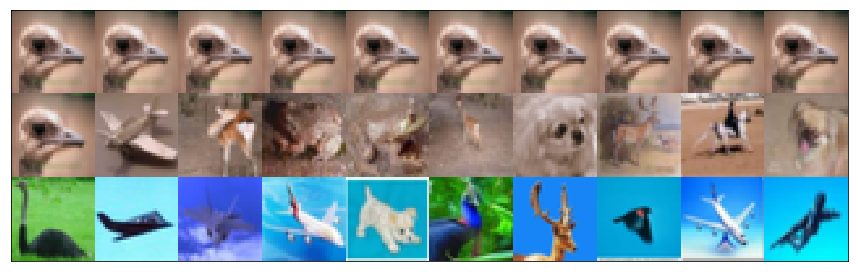

In [72]:
batch = tqdm(cifar10_test_dl, total = len(cifar10_test_dl) // BATCH_SIZE)
loss_hist = []
images = []

for x, label in batch:
    x = x.to(device)
    label = label.to(device)
    y, M = encoder(x)
    original = x.detach().cpu().unbind(0)
    enc = y.detach().cpu().unbind(0)
    [images.append(elem) for elem in zip(enc, original)]

#l2 norm
def dist(x, y):
    return torch.norm(x - y, 2).item() 

def k_analysis(subject, images):
    images = sorted(images, key=lambda elem: dist(subject[0], elem[0]))
    
    replicated = [subject for _ in range(10)]
    nearest = images[:10]
    farthest = images[-10:]

    top_row = np.concatenate([img[1].permute(1, 2, 0).cpu().numpy() for img in replicated], axis = 1)
    middle_row = np.concatenate([img[1].permute(1, 2, 0).cpu().numpy() for img in nearest], axis = 1)
    bottom_row = np.concatenate([img[1].permute(1, 2, 0).cpu().numpy() for img in farthest], axis = 1)
    
    _img = np.concatenate((top_row, middle_row, bottom_row), axis=0)

    plt.figure(figsize=(15,25))
    plt.imshow(_img)
    plt.xticks([]), plt.yticks([])
    plt.show()


current = images[random.randint(0, len(images))]
k_analysis(current, images)

<font size="3"> **Top row**: shows one image chosen randomly, in **middle** and **bottom** row we can see, respectively, the nearest and furthers imagens, according to L2 distance of encoded representation. Even with 200 epochs, the classifier can distinguish images with different color intensities. </font>

In [23]:
epochs_clf = 100
check = 20
clf = Classifier()
clf.train()
clf = clf.to(device)
adam = Adam(clf.parameters(), lr = 1e-4)
loss_func = nn.CrossEntropyLoss()

for epoch in range(1, epochs_clf + 1):
    batch = tqdm(cifar10_train_dl, total = len(cifar10_train_dl) // BATCH_SIZE)
    loss_hist = []
    for x, targets in batch:
        x = x.to(device)
        targets = targets.to(device)
        
        adam.zero_grad()
        y, _ = encoder(x)
        y = clf(y)

        loss = loss_func(y, targets)
        loss_hist.append(loss.detach().item())
        batch.set_description(f'{epoch} - Train Loss: {stats.mean(loss_hist)}')
        
        loss.backward()
        adam.step()

        if epoch % check == 0:
            file = Path(f"./deepinfomax/epoch_{epoch}_clf_2.pkl")
            file.parent.mkdir(parents=True, exist_ok=True)
            torch.save(clf.state_dict(), str(file))

0it [00:00, ?it/s]/home/virtualspaceman/workspace/tf/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]
1 - Train Loss: 2.260351513593625: : 195it [00:25,  7.60it/s] 
2 - Train Loss: 2.1945878016643037: : 195it [00:26,  7.40it/s]
3 - Train Loss: 2.149856117444161: : 195it [00:26,  7.00it/s] 
4 - Train Loss: 2.1097428309611783: : 195it [00:28,  6.89it/s]
5 - Train Loss: 2.0776397864023846: : 195it [00:28,  6.94it/s]
6 - Train Loss: 2.0575077949426115: : 195it [00:28,  6.81it/s]
7 - Train Loss: 2.0417798684193538: : 195it [00:28,  6.90it/s]
8 - Train Loss: 2.029785236945519: : 195it [00:28,  6.84it/s] 
9 - Train Loss: 2.0210964453526032: : 195it [00:28,  6.69it/s]
10 - Train Loss: 2.01243971372262: : 195it [00:28,  6.82it/s]  
11 - Train Loss: 2.0046630669862795: : 195it [00:28,  6.72it/s]
12 - Train Loss: 1.9984008165506215: : 195it [00:29,  6.89i

In [28]:
clf.eval()
true = []
pred = []

batch = tqdm(cifar10_test_dl, total = len(cifar10_test_dl) // BATCH_SIZE)
loss_hist = []
for x, targets in batch:
    x = x.to(device)
    targets = targets.to(device)

    y, _ = encoder(x)
    y = clf(y)
    loss = loss_func(y, targets)
    loss_hist.append(loss.detach().item())
    batch.set_description(f'Test Loss: {stats.mean(loss_hist)}')

    _, predicted = y.detach().max(1)
    [pred.append(elem.cpu().numpy()) for elem in predicted]
    [true.append(elem.cpu().numpy()) for elem in targets]


print(classification_report(true, pred, target_names = classes))
mat = confusion_matrix(true, pred)
scores_per_class = mat.diagonal()/mat.sum(axis=1)
print(scores_per_class)


0it [00:00, ?it/s]/home/virtualspaceman/workspace/tf/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]

Test Loss: 1.886088490486145: : 0it [00:00, ?it/s]
Test Loss: 1.8732978105545044: : 0it [00:00, ?it/s]
Test Loss: 1.8732978105545044: : 2it [00:00, 12.43it/s]
Test Loss: 1.9016037384668987: : 2it [00:00, 12.43it/s]
Test Loss: 1.9049761593341827: : 2it [00:00, 12.43it/s]
Test Loss: 1.9049761593341827: : 4it [00:00, 12.95it/s]
Test Loss: 1.9001819372177124: : 4it [00:00, 12.95it/s]
Test Loss: 1.9005443056424458: : 4it [00:00, 12.95it/s]
Test Loss: 1.9005443056424458: : 6it [00:00, 13.38it/s]
Test Loss: 1.904215625354222: : 6it [00:00, 13.38it/s] 
Test Loss: 1.907378077507019: : 6it [00:00, 13.38it/s]
Test Loss: 1.907378077507019: : 8it [00:00, 13.84it/s]
Test Loss: 1.9083368513319228: : 8it [00:00, 13.84it/s]
Test Loss: 1.9122190952301026: : 8i

              precision    recall  f1-score   support

    airplane       0.59      0.59      0.59      1000
  automobile       0.60      0.69      0.64       997
        bird       0.47      0.39      0.43       997
         cat       0.42      0.42      0.42       999
        deer       0.53      0.46      0.50       999
         dog       0.50      0.54      0.52       999
        frog       0.58      0.68      0.63       999
       horse       0.63      0.58      0.61       998
        ship       0.66      0.70      0.68       997
       truck       0.65      0.61      0.63       999

   micro avg       0.57      0.57      0.57      9984
   macro avg       0.56      0.57      0.56      9984
weighted avg       0.56      0.57      0.56      9984

[0.586      0.68706118 0.38816449 0.41541542 0.46446446 0.53853854
 0.68268268 0.58316633 0.69909729 0.61261261]


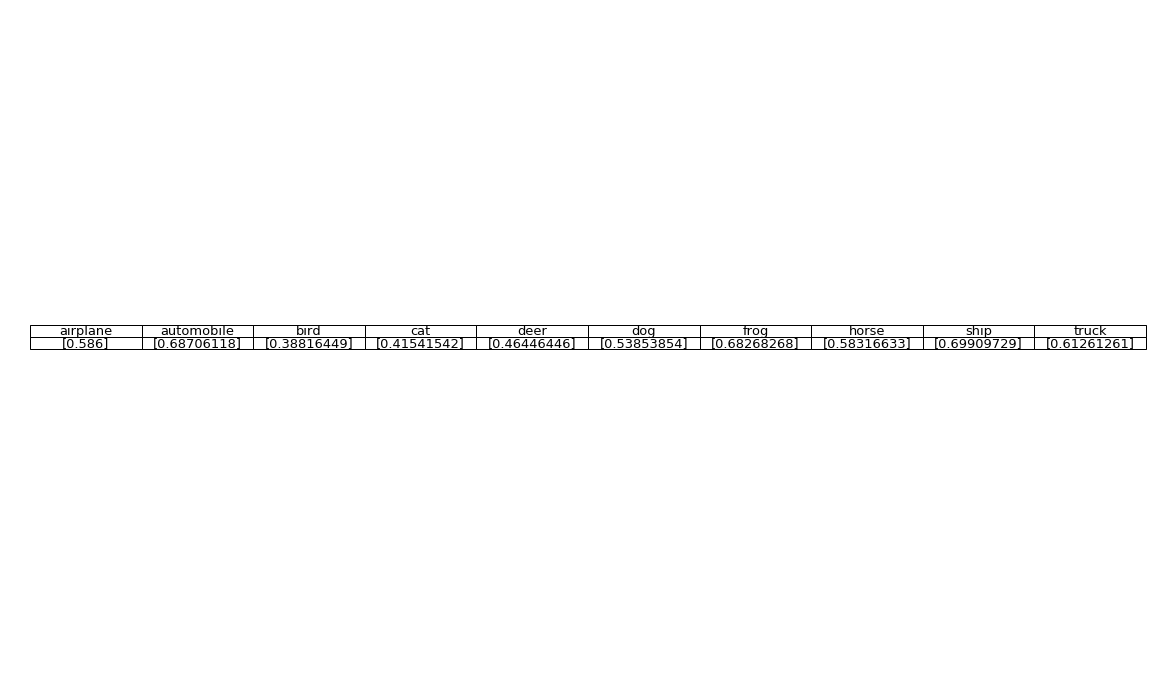

In [89]:
plt.figure(figsize=(20,12))
table = plt.table(cellText=np.expand_dims(scores_per_class, axis=0), 
                    colLabels=classes, loc='center',cellLoc='center')
table.set_fontsize(30)
plt.axis("off")
plt.show()


In [10]:
X_train, y_train, X_test, y_test = [], [], [], []

batch = tqdm(cifar10_train_dl, total = len(cifar10_train_dl) // BATCH_SIZE)
for x, labels in batch:
    x = x.to(device)
    y, _ = encoder(x)
    for _y, _target in zip(y, labels):
        X_train.append(_y.detach().cpu().numpy())
        y_train.append(_target.cpu().numpy())

        
batch = tqdm(cifar10_test_dl, total = len(cifar10_test_dl) // BATCH_SIZE)
for x, labels in batch:
    x = x.to(device)
    y, _ = encoder(x)
    for _y, _target in zip(y, labels):
        X_test.append(_y.detach().cpu().numpy())
        y_test.append(_target.cpu().numpy())


195it [00:12, 16.13it/s]
39it [00:02, 16.31it/s]


In [11]:
from sklearn import svm
svm_clf = svm.SVC(gamma = "auto")
svm_clf.fit(X_train, y_train)
y_pred = svm_clf.predict(X_test)
mat = confusion_matrix(y_test,y_pred)
print(mat)
print(classification_report(y_test,y_pred, target_names = classes))
print(accuracy_score(y_test, y_pred))
scores_per_class = mat.diagonal()/mat.sum(axis=1)
print(scores_per_class)

[[229   4  16  17   1 617   4  18  45  48]
 [  4 138   0   5   0 714   0  13  10 113]
 [ 21   0 206  19  31 658  30  26   3   5]
 [  5   0  19 177   5 734  25  12   1  19]
 [  6   0  58  18 194 608  56  50   3   4]
 [  1   0  10  29   5 922  11  18   0   4]
 [  1   0  27  17  20 631 276  23   1   3]
 [  5   1   5  10   4 649   7 301   2  13]
 [ 23   6   6   3   1 697   0  11 197  56]
 [ 11  13   0   5   0 648   0  13   5 304]]
              precision    recall  f1-score   support

    airplane       0.75      0.23      0.35       999
  automobile       0.85      0.14      0.24       997
        bird       0.59      0.21      0.31       999
         cat       0.59      0.18      0.27       997
        deer       0.74      0.19      0.31       997
         dog       0.13      0.92      0.23      1000
        frog       0.67      0.28      0.39       999
       horse       0.62      0.30      0.41       997
        ship       0.74      0.20      0.31      1000
       truck       0.53     

Results for hyperparameters 0.5, 1.0 and 0.1 for non-linear and linear classification: 

![](https://drive.google.com/uc?id=1EG3mzUa7QYR0BSU6rPOgXrFlynPn_Tjk)